<a href="https://colab.research.google.com/github/delhian/funny-tasks/blob/main/time_series_and_predicted_interval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

import statsmodels.api as sm
import numpy as np
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt

from datetime import date, timedelta
from datetime import datetime
import math
import scipy.stats as st
from matplotlib.animation import FuncAnimation

from sklearn.linear_model import QuantileRegressor, LinearRegression

In [ ]:
ls ./30112021

Small_Files_nine_months.jpg         Small_Files_three_months.jpg
Small_Files_nine_months_data.xlsx   Small_Files_three_months_data.xlsx
Small_Files_six_months.jpg          Small_Files_two_weeks.jpg
Small_Files_six_months_data.xlsx    Small_Files_two_weeks_data.xlsx


In [ ]:
files = ['Small_Files_nine_months_data.xlsx',
         'Small_Files_six_months_data.xlsx',
         'Small_Files_three_months_data.xlsx',
         'Small_Files_two_weeks_data.xlsx']

df = pd.read_excel(io = os.path.join(r'./30112021', files[0]),  parse_dates = ['Time'], ) 
df = df.fillna(0)

df = df.set_index('Time')

In [ ]:


col_subset = [x for x in df.columns if '/data/core/internal' in x.lower()]

# col_subset = df.columns[1:]

y = []

for ind, col in enumerate(col_subset):
    downsampled = df[[col]].resample('1D').fillna(method = 'bfill')
    if ind == 0:
        df_new = downsampled.drop(columns = col)
    y.append(downsampled[col].values.tolist())
    df_new[col] = downsampled
    
x = downsampled.index

df =df_new
    
del df_new

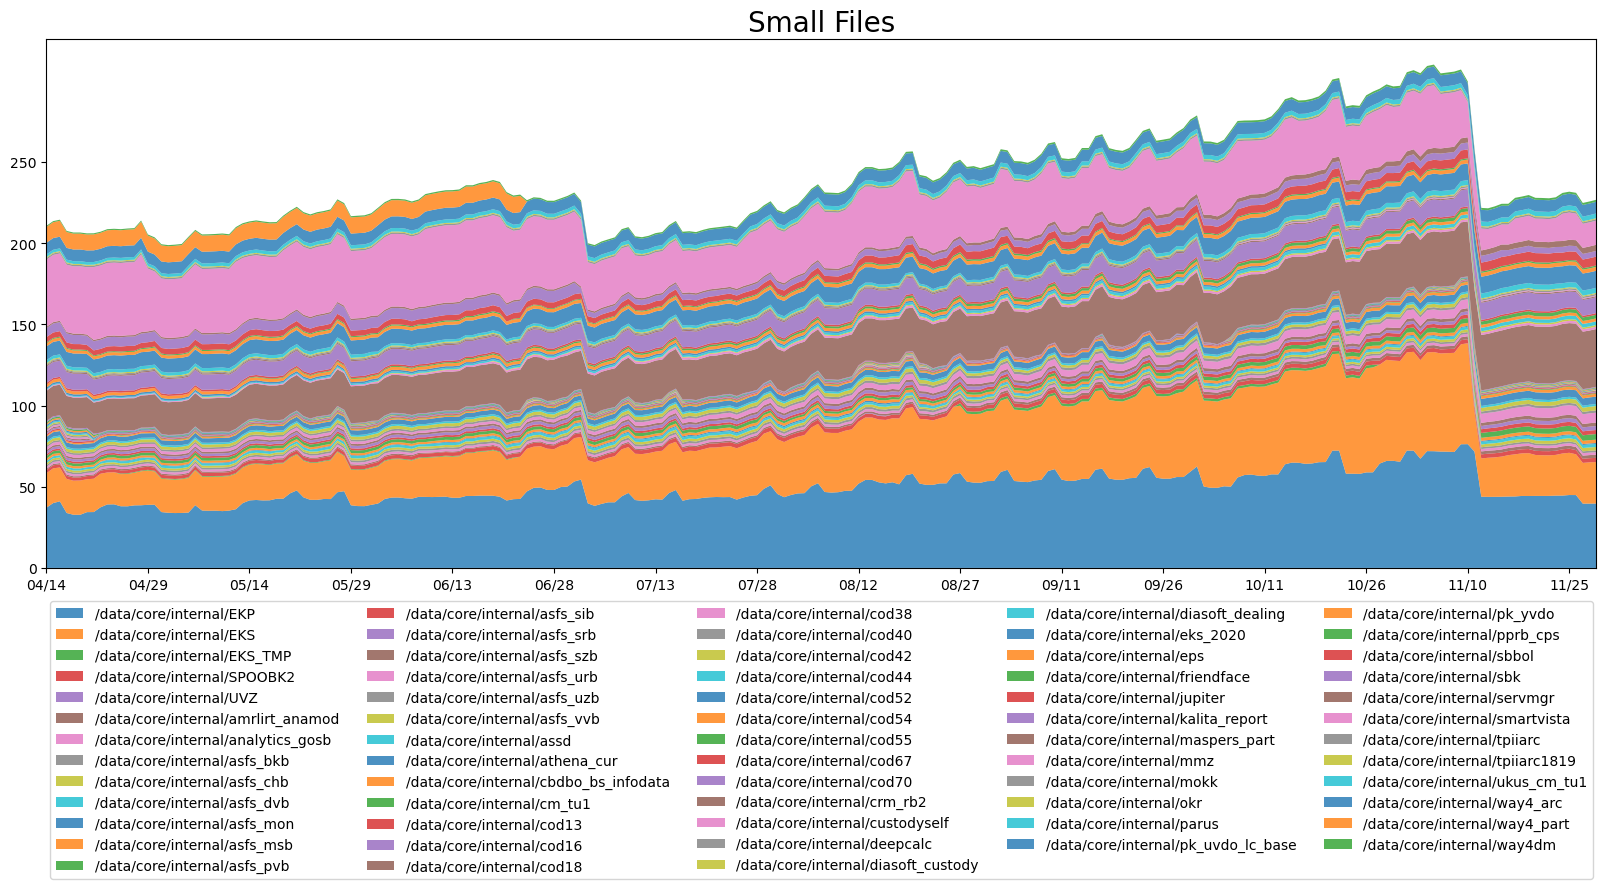

                               replica   min   max  current
0              /data/core/internal/EKP  32.7  76.2     39.7
1              /data/core/internal/EKS  19.7  64.6     25.6
2       /data/core/internal/smartvista  12.3  47.8     14.8
3          /data/core/internal/crm_rb2  18.6  35.6     35.6
4    /data/core/internal/kalita_report   9.3  10.6      9.7
5  /data/core/internal/pk_uvdo_lc_base   8.5  10.5     10.5
6        /data/core/internal/way4_part   0.0  10.0      0.0
7         /data/core/internal/way4_arc   7.2   7.2      7.2
8              /data/core/internal/sbk   3.1   7.1      3.5
9         /data/core/internal/asfs_urb   1.2   6.1      6.1


In [ ]:

# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(20, 7), dpi= 100)

ax = plt.gca()
ax.stackplot(x, y, labels=col_subset, alpha=0.8)

ax.set_title('Small Files', fontsize=20)

plt.xticks(x[::15], fontsize=10, horizontalalignment='center')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

values = np.arange(0, 300, 50)
value_increment = 1000000

plt.yticks(values * value_increment, ['%d' % val for val in values], fontsize=10)
plt.xlim(x[0], x[-1])


ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=False, ncol=5)

plt.show()

results = pd.melt(df[col_subset],value_vars=col_subset).groupby('variable')\
.agg({'value':['min', 'max', 'last']}).reset_index()

results.columns = ['replica', 'min', 'max', 'current']
million = 1000000
results['min'] = results['min']/million
results['max'] = results['max']/million
results['current'] = results['current']/million
results = round(results, 1)
results = results.sort_values(['max'], ascending = False).reset_index(drop=True)

print(results[:10])

<IPython.core.display.Javascript object>


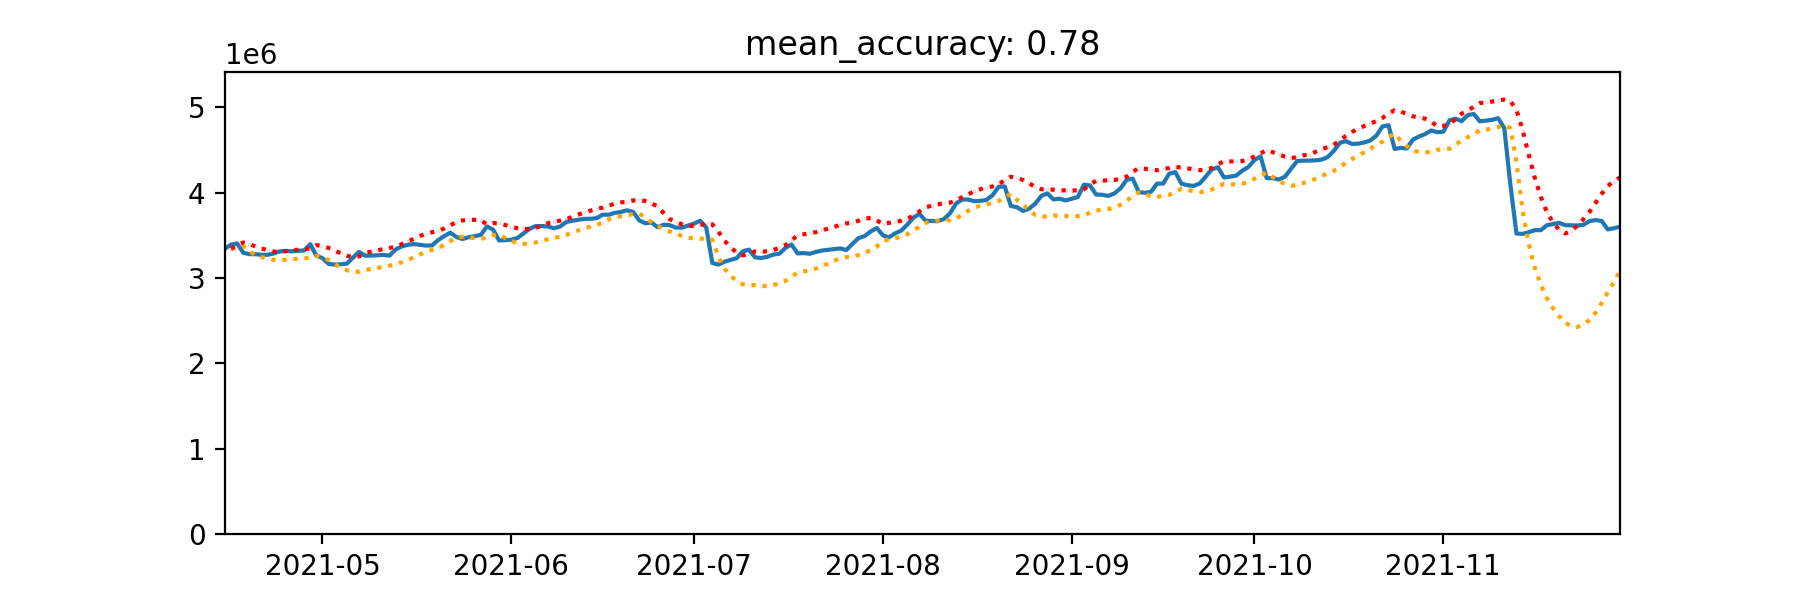

In [ ]:
# %matplotlib inline

%matplotlib notebook

date_format = "%Y-%m-%d"
start_date, end_date = '2021-04-05' , '2021-12-30'

replica = '/data/core/internal/smartvista'

max_points = len(df[replica][start_date: end_date]) -2


class Scope:
    def __init__(self, df, ax, start_date, end_date):
        self.ax = ax
        self.accuracy = []
        self.replica_df = df[start_date: end_date]
        self.start_x = min(self.replica_df[start_date: end_date].index)
        self.end_x = max(self.replica_df[start_date: end_date].index)
        self.start_y = self.replica_df[self.start_x:self.start_x].values[0]
        self.min_y = self.replica_df[start_date: end_date].min()
        self.max_y = self.replica_df[start_date: end_date].max()
        self.days_forecast = 14
        self.days_before_init = 28
        self.days_before = self.days_before_init
        
        self.x = [self.start_x]
        
#         ПРОГНОЗИРУЕМЫЙ ПЕРИОД self.days_forecast:
        self.x_forecast = [self.start_x + timedelta(days = 1 + x) for x in range(self.days_forecast)]
        
        self.y = [self.start_y]
        
        self.y_lower = [self.start_y] * self.days_forecast
        
        self.y_upper = [self.start_y] * self.days_forecast

        self.y_2 = [0]    
        
        self.line = Line2D(self.x, self.y)
        
        self.line_lower = Line2D(self.x, self.y_lower, marker ='.', linestyle='dotted', color ='orange', markersize=.1)
        self.line_upper = Line2D(self.x_forecast, self.y_upper, marker ='.', linestyle='dotted', color ='red', markersize=.1)

        self.ax.set_ylim(0, self.max_y *1.1)
        
        self.ax.set_xlim(self.start_x, self.end_x)   
        
        self.ax.add_line(self.line)
        self.ax.add_line(self.line_lower)
        self.ax.add_line(self.line_upper)
#         self.ax[1].add_line(self.line_2)


    def _get_predicted_interval(self, lst):
#        Naïve forecasts: https://otexts.com/fpp2/prediction-intervals.html
        # Prediction interval -> z
        # 75%	1.15
        # 90%	1.64
        # 95%	1.96
        # 99%	2,326
        z = 1.96

        x = list(range(-self.days_forecast, len(lst)))[-self.days_before:]
        lst_ = ([lst[0]]*self.days_forecast + lst)[-self.days_before:]

        x_forecast = np.array(range(x[-1] + 1, x[-1] + self.days_forecast + 1))
        poly_x = [x * x for x in x]
        x_poly_x = np.stack([x, poly_x]).T
        clf = LinearRegression().fit(x_poly_x, lst_)
#         Остатки и их несмещенное стандартное отклонение:
        resideals = [x - y for x, y in zip(lst_, clf.predict(x_poly_x))]
        s = np.std(resideals, ddof = 1)

        forecasts_upper = [clf.intercept_ + t * clf.coef_[0] + clf.coef_[1] * t * t + \
                           s * z * (index + 1) ** 0.5 for index, t in enumerate(x_forecast)]
        forecasts_lower  = [clf.intercept_ + t * clf.coef_[0] + clf.coef_[1] * t * t - \
                            s * z * (index + 1) ** 0.5 for index, t in enumerate(x_forecast)]

        return forecasts_lower, forecasts_upper

    
    def update(self, y):
        if self.x[-1] > self.end_x:
            self.accuracy = []
            self.x = [self.start_x]
            self.x_forecast = [self.start_x + timedelta(days = 1 + x) for x in range(self.days_forecast)]
            self.y = [self.start_y]
            self.y_lower = [self.start_y] * self.days_forecast
            self.y_upper = [self.start_y] * self.days_forecast
#             self.y_2 = [0]
            
            self.ax.set_xlim(self.start_x, self.end_x)
#             self.ax.figure.canvas.draw()
                
#         СМЕЩАЕМСЯ НА 1 СУТКИ:
        self.x.append(self.x[-1] + timedelta(days=1))
        
#         СМЕЩАЕМ ПЕРИОД ПРЕДСКАЗАНИЯ НА 1 СУТКИ:
        self.x_forecast = self.x_forecast + [self.x_forecast[-1] + timedelta(days=1)]
        
        y = self.replica_df[self.x[-1].strftime(date_format)]
        self.y.append(y)
        
        
        flag = 2 * abs(self.y[-1] - self.y[-2]) /(self.y[-1] + self.y[-2])
        self.y_2.append(flag)
        
#      ЕСЛИ ПРОИСХОДИТ СИЛЬНЫЙ СКАЧОК "ВОЗРАЩАЕМСЯ В НАЧАЛО" 
        if flag > 0.3:
            self.days_before = 0
        
        if self.days_before < self.days_before_init:
            self.days_before += 1
            
#      ПОЛУЧАЕМ ПРЕДСКАЗАНИЯ НА ПЕРИОД days_forecast НИЖНЯЯ И ВЕРНЯЯ ГРАНИЦЫ (predicted interval)
#      ИСПОЛЬЗУЮ ПЕРИОД self.days_before

        add_y_lower, add_y_upper = self._get_predicted_interval(self.y)

        self.y_lower = self.y_lower[:1 - self.days_forecast] + add_y_lower
        self.y_upper = self.y_upper[:1 - self.days_forecast] + add_y_upper
        
#     ИСТИННЫЕ ЗНАЧЕНИЯ :
        if self.x_forecast[-1] < self.end_x:
            ground_true = self.replica_df.loc[self.x_forecast[-self.days_forecast:]].values
            accuracy = (self.days_forecast - sum((ground_true < add_y_lower) + \
                                                 (ground_true > add_y_upper)))/self.days_forecast    
            self.accuracy.append(accuracy)


        self.line.set_data(self.x, self.y)
        self.line_lower.set_data(self.x_forecast, self.y_lower)
        self.line_upper.set_data(self.x_forecast, self.y_upper)
        
        ax.set_title(f'mean_accuracy: {np.round(np.mean(self.accuracy[self.days_forecast:]), 2)}')
 
                            
        return self.line, self.line_lower, self.line_upper
    

fig = plt.figure(figsize=(9,3))

ax = fig.add_subplot(111)

scope = Scope(np.mean(df, axis = 1), ax, start_date, end_date)

ani = FuncAnimation(fig, scope.update, max_points, interval =100, repeat = False)

plt.show()